##### Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

In [2]:
np.random.seed(21)

##### Loading and initial inspection

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv",
                 header = None)

In [4]:
df.shape

(747, 30)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [6]:
covariates = {i: f"x{i-4}" for i in range(5, 30)}
df.rename(columns={
    0: 'treat_binary',
    1: 'observed',
    2: 'counterfactual',
    3: 'cond_mean_treat',
    4: 'cond_mean_control',
    **covariates
}, inplace=True)

In [7]:
df.columns = df.columns.astype(str)

In [8]:
df.head()

,treat_binary,observed,counterfactual,cond_mean_treat,cond_mean_control,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [9]:
ate = np.mean(df['cond_mean_treat'] - df['cond_mean_control'])
print(f"ATE: {ate}")

ATE: -4.016066896118338


##### Overlap

In [10]:
non_covariate_cols = ['treat_binary', 'observed', 'counterfactual', 'cond_mean_treat', 'cond_mean_control']
covariate_cols = [col for col in df.columns if col not in non_covariate_cols]

In [11]:
def propensity_scores(df, covariate_cols, treatment_col):
    X = df[covariate_cols]
    y = df[treatment_col]

    log_model = LogisticRegression()
    log_model.fit(X, y)
    
    prop_scores = log_model.predict_proba(X)[:, 1]
    return prop_scores

In [12]:
df['prop_score'] = propensity_scores(df, covariate_cols, 'treat_binary')

In [13]:
def plot_propensity_scores(df, treatment_col, prop_score_col):

    plt.figure(figsize=(10, 6))

    treated = df[df[treatment_col] == 1][prop_score_col]
    control = df[df[treatment_col] == 0][prop_score_col]

    plt.hist(treated, bins=30, alpha=0.6, label='Treated (1)', density=True, color='blue')
    plt.hist(control, bins=30, alpha=0.6, label='Control (0)', density=True, color='orange')

    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.title('Propensity Score Densities (by Treatment Status)')
    plt.show()

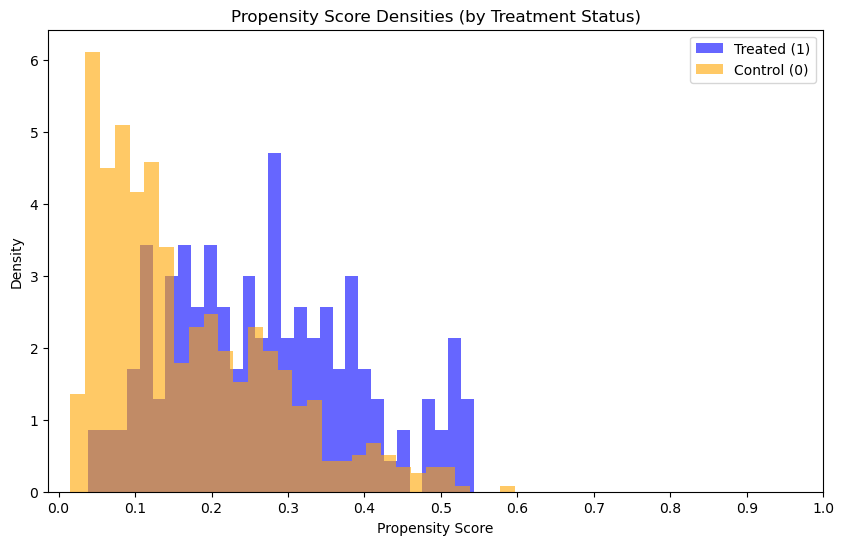

In [15]:
plot_propensity_scores(df, 'treat_binary', 'prop_score')

##### Basis expansion

In [ ]:
"""
new_features = PolynomialFeatures(
    degree=2,
    interaction_only=False,
    include_bias=False
)
"""

'\nnew_features = PolynomialFeatures(\n    degree=2,\n    interaction_only=False,\n    include_bias=False\n)\n'

In [ ]:
"""
preprocessor = ColumnTransformer(
    transformers=[
        ("pass", "passthrough", non_covariate_cols),
        ("augment", new_features, covariate_cols)
    ],
    verbose_feature_names_out=False
)
"""

'\npreprocessor = ColumnTransformer(\n    transformers=[\n        ("pass", "passthrough", non_covariate_cols),\n        ("augment", new_features, covariate_cols)\n    ],\n    verbose_feature_names_out=False\n)\n'

In [ ]:
"""
df_augmented = preprocessor.fit_transform(df)
augmented_columns = preprocessor.get_feature_names_out()
df_augmented = pd.DataFrame(df_augmented, columns=augmented_columns)
df_augmented
"""

'\ndf_augmented = preprocessor.fit_transform(df)\naugmented_columns = preprocessor.get_feature_names_out()\ndf_augmented = pd.DataFrame(df_augmented, columns=augmented_columns)\ndf_augmented\n'

##### Synthetic into-treatment selection bias

In [16]:
strength = 5
selection_covariates = (df['x1'] + df['x2'] + df['x3'])
scores = expit(strength * selection_covariates)

In [17]:
df['treat_binary_bias'] = np.random.binomial(1, scores)

In [18]:
df['prop_score_bias'] = propensity_scores(df, covariate_cols, 'treat_binary_bias')

In [19]:
covariate_cols

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25']

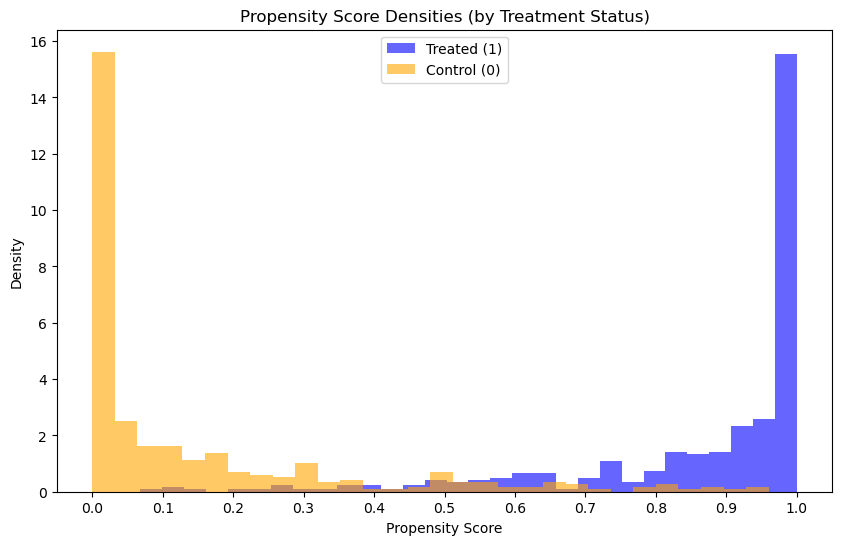

In [20]:
plot_propensity_scores(df, 'treat_binary_bias', 'prop_score_bias')

In [21]:
df['observed_bias'] = np.where(df['treat_binary_bias'] == 1, df['observed'], df['counterfactual'])
df['counterfactual_bias'] = np.where(df['treat_binary_bias'] == 0, df['observed'], df['counterfactual'])

In [25]:
df = df[[
    "treat_binary",
    "prop_score",
    "observed",
    "counterfactual",
    "treat_binary_bias",
    "prop_score_bias",
    "observed_bias",
    "counterfactual_bias",
    "cond_mean_treat",
    "cond_mean_control",
    *covariate_cols
]]

In [26]:
df.head()

,treat_binary,prop_score,observed,counterfactual,treat_binary_bias,prop_score_bias,observed_bias,counterfactual_bias,cond_mean_treat,cond_mean_control,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,0.283505,5.599916,4.318780,1,0.720516,5.599916,4.318780,3.268256,6.854457,...,1,1,1,1,0,0,0,0,0,0
1,0,0.068051,6.875856,7.856495,0,0.000025,7.856495,6.875856,6.636059,7.562718,...,1,1,1,1,0,0,0,0,0,0
2,0,0.107717,2.996273,6.633952,0,0.002957,6.633952,2.996273,1.570536,6.121617,...,1,0,1,1,0,0,0,0,0,0
3,0,0.129523,1.366206,5.697239,0,0.033514,5.697239,1.366206,1.244738,5.889125,...,1,0,1,1,0,0,0,0,0,0
4,0,0.092541,1.963538,6.202582,0,0.004468,6.202582,1.963538,1.685048,6.191994,...,1,1,1,1,0,0,0,0,0,0
